In [339]:
# disable compiler warnings
import os

# imports 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense
from typing import List
import datetime
from tqdm.notebook import tqdm


from tensorflow.python.client import device_lib
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [340]:
(train_ds, val_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
#tfds.show_examples(train_ds, ds_info)

In [341]:
# gets in a dataset and returns target values
def prepare_data(dataset, batch_size, noise_variance):
    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, targets: (tf.cast(img, tf.float32), targets))

    # convert image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, targets: ((img/128.)-1., targets))

    # replace targets with initial img, replace initial img with img+noise
    dataset = dataset.map(lambda img, target: (img + tf.random.normal(img.shape, mean=0, stddev=noise_variance), img))

    # clip min value to -1 and max value to +1
    dataset = dataset.map(lambda img, target: (tf.clip_by_value(img, clip_value_min=-1, clip_value_max=1), target))

    dataset = dataset.cache()
    dataset = dataset.shuffle(4096)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [342]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Encoder, self).__init__()
  
        self.my_layers = [tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(14, 14, 1)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(64, activation='relu')
                         ]

    @tf.function
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x)
        return x

In [343]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Decoder, self).__init__()

        self.my_layers = [tf.keras.layers.Dense(14 * 14, activation='relu'),
                          tf.keras.layers.Reshape((14, 14, 1)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')
                         ]

    @tf.function
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x)
        return x

In [344]:
class Autoencoder(tf.keras.Model):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()


    @tf.function
    def call(self, x, training=False):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [345]:
# overall hyperparameters to compare with and without overfitting precautions methods
epochs = 10
batch_size = 64
noise_variance = 0.5

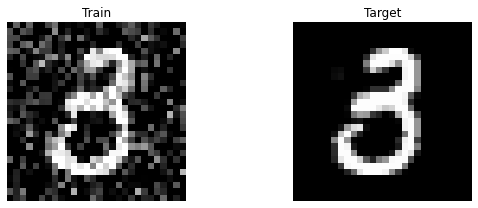

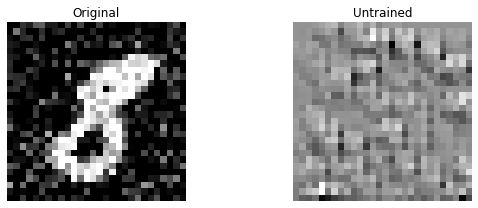

In [346]:
model = Autoencoder()

train_dataset = prepare_data(train_ds, batch_size, noise_variance)
val_dataset = prepare_data(val_ds, batch_size, noise_variance)

for img, label in train_dataset.take(1):
    plt.figure(figsize=(9, 3))
    
    plt.subplot(121)
    plt.title('Train')
    plt.axis('off')
    plt.imshow(img[0,:,:,0], cmap='gray')

    plt.subplot(122)
    plt.title('Target')
    plt.axis('off')
    plt.imshow(label[0,:,:,0], cmap='gray')

    plt.tight_layout()
    plt.show()

for img, label in train_dataset.take(1):
    plt.figure(figsize=(9, 3))
    
    plt.subplot(121)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(img[0,:,:,0], cmap='gray')

    plt.subplot(122)
    plt.title('Untrained')
    plt.axis('off')
    plt.imshow(model(img)[0,:,:,0], cmap='gray')

    plt.tight_layout()
    plt.show()

In [347]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='mean_squared_error'
              )

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    batch_size=batch_size,
                    epochs=15)

model.summary()

Epoch 1/15
938/938 [==============================] - 17s 17ms/step - loss: 0.9166 - val_loss: 0.8595
Epoch 2/15
938/938 [==============================] - 7s 7ms/step - loss: 0.8582 - val_loss: 0.8535
Epoch 3/15
938/938 [==============================] - 7s 7ms/step - loss: 0.8540 - val_loss: 0.8510
Epoch 4/15
938/938 [==============================] - 7s 7ms/step - loss: 0.8521 - val_loss: 0.8492
Epoch 5/15
938/938 [==============================] - 7s 8ms/step - loss: 0.8512 - val_loss: 0.8500
Epoch 6/15
938/938 [==============================] - 7s 7ms/step - loss: 0.8506 - val_loss: 0.8489
Epoch 7/15
938/938 [==============================] - 7s 7ms/step - loss: 0.8502 - val_loss: 0.8480
Epoch 8/15
938/938 [==============================] - 7s 7ms/step - loss: 0.8498 - val_loss: 0.8476
Epoch 9/15
938/938 [==============================] - 7s 7ms/step - loss: 0.8495 - val_loss: 0.8474
Epoch 10/15
938/938 [==============================] - 7s 7ms/step - loss: 0.8493 - val_loss: 0.84

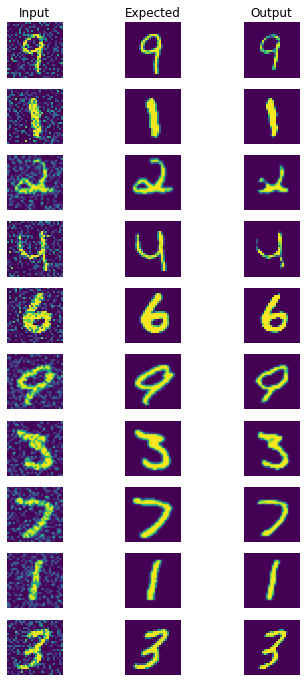

In [348]:
# Plot example images
figure = plt.figure(figsize=(6, 12))
rows = 10
cols = 3

def show_image(img, i, name):
  figure.add_subplot(rows, cols, i)
  plt.imshow(img.reshape((28, 28)))
  plt.axis('off')
  if i < 4:
    plt.title(name)

i = 1
for imgs, targets in val_dataset.shuffle(4096).take(rows):
  output = model(imgs[0].reshape((1, 28, 28, 1)))
  
  show_image(imgs[0], i, 'Input')
  i += 1

  show_image(targets[0], i, 'Expected')
  i += 1

  show_image(output, i, 'Output')
  i += 1
